<a href="https://colab.research.google.com/github/SudeepSarkar/Computer-Vision-Course/blob/main/Lecture_7__Kalman_Filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Useful prior code


Mount Google drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')
!ls /content/drive/MyDrive/Colab\ Notebooks/data/

Mounted at /content/drive
hawaii.png   house_facade.png  MOT16-08-raw.webm    VIRAT_S_000101
house_1.png  id_rsa	       mountain_peak_1.png
house_2.png  lizard.jpg        mountain_peak_2.png


Standard Import

In [4]:
import numpy as np
import torch
import cv2
import matplotlib.pyplot as plt
import scipy.ndimage as scimage
import torch.nn as nn
from skimage import io
from skimage.feature import peak_local_max


np.set_printoptions(precision=2)

Code to display error ellipses

In [5]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
# This function was taken/adapted from https://matplotlib.org/devdocs/gallery/statistics/confidence_ellipse.html
def confidence_ellipse(cov, mu, ax, n_std=1.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse 
    Parameters
    ----------
    cov : 2 by 2 covariance matrix
        Input data.
    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.
    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`
    Returns
    -------
    Ellipse
    """
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)
    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = mu[0]
    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = mu[1]
    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)
    ellipse.set_transform(transf + ax.transData)
    return ellipse

Code to reduce size of an image

In [6]:
def reduce_size (img, scale_percent = 20) :
  #calculate the scale_percent of original dimensions
  width = int(img.shape[1] * scale_percent / 100)
  height = int(img.shape[0] * scale_percent / 100)
  # resize image
  return (cv2.resize(img, (width, height)))

Distance of point to a set of points

In [7]:
#`distance_batch` contains some broadcast magic that allows us to compute the distance from each point in a batch to all points in the data.
# See - https://numpy.org/doc/stable/user/basics.broadcasting.html
#  and https://scipy-lectures.org/intro/numpy/operations.html
def distance_batch(a, b):
    return torch.sqrt(((a[None,:] - b[:,None]) ** 2).sum(2))

def distance (x, X):
    return np.sqrt(((x - X) ** 2).sum(1))


# Gaussian weighted filters

In [8]:
def gaussian (x, sigma):
    g = np.exp(-(x**2/(2*sigma*sigma)))*(1/(np.sqrt(2*np.pi)*sigma))
    return (g/g.sum())

# Gaussian derivative filter

In [9]:
#------------------------------------------------------------------
def first_derivative_of_gaussian (x, sigma):
    dg = np.exp(-(x**2/(2*sigma*sigma)))*(-x/(np.sqrt(2*np.pi)*sigma**3))
    return (dg)

# 2D Gaussian filter kernel in torch


In [10]:
def gaussian_kernel_multi_channel (input_ch, output_ch, sigma = 3, type='not_independent') :
# produces a [input_ch, output_ch, 2*N+1, 2*N+1] sized multi-channel gaussian kernel, where
# N is 3*sigma+1. 
# if type='independent' and the number of input_ch and output_ch are the same number
# then it produces a kernel that processes each channel independently from the others.
# the cross channel weights are zeroed out.

    N = np.round(3*(sigma+1))
    x = np.arange(-N, N+1)  # Note the width of the kernel, need to be this large to capture most of the shape
    g_1D = gaussian(x, sigma) # 1D gaussian kernel
    # creating 2D kernel using broadcasting of the 1D kernels
    gaussian_2D = (g_1D[:,None]*g_1D[None,:])
    gaussian_2D = gaussian_2D/gaussian_2D.sum()
    
    gaussian_kernel = np.zeros([input_ch, output_ch, 2*N+1, 2*N+1]) 
    if  (type == 'independent') and (input_ch == output_ch) :
        #print('Using {} Gaussian kernels on {} independent channels'.format(input_ch,input_ch))
        for i in range (input_ch) :
            gaussian_kernel[i,i,:,:] = gaussian_2D[:, :]
    else :
        print('Using {} Gaussian kernels to bridge {} input channels with {} output channels'.format(input_ch*output_ch, input_ch, output_ch))
        for i in range (input_ch) :
            for j in range (output_ch) :
                gaussian_kernel[i,j,:,:] = gaussian_2D[:, :]
    
    return(gaussian_kernel, N)

# 2D gradient filter kernel in torch

In [11]:
def gradient_gaussian_kernel (sigma = 3) :
# produces a [output_ch=2, input_ch=1,  2*N+1, 2*N+1] sized multi-channel first derivative of gaussian kernel
# with respect to the x direction, where N is 3*sigma+1. 

    N = np.round(3*(sigma+1))
    x = np.arange(-N, N+1)  # Note the width of the kernel, need to be this large to capture most of the shape
    g_1D = gaussian(x, sigma) # 1D gaussian kernel
    g_1D = g_1D/g_1D.sum()
    g_1D_dx = first_derivative_of_gaussian(x, sigma)

    # creating 2D kernel using broadcasting of the 1D kernels
    input_ch=1
    output_ch=2
    gradient_kernel = np.zeros([output_ch, input_ch, 2*N+1, 2*N+1]) 
    gradient_kernel[0, 0, :, :] = g_1D[:,None]*g_1D_dx[None,:]
    gradient_kernel[1, 0, :, :] = g_1D_dx[:,None]*g_1D[None,:]

    return(gradient_kernel, N)

# Harris points

In [12]:
def detect_harris_points_torch (device, input, sigma=3,min_distance=20, num_peaks=40, figure='no') :
    # 
    # device -- "cpu" or 'cuda:0' or ...
    # input -- 4D torch tensor of images (batch_size by num_channels=1 by height by width) 
    # sigma -- spread for the Gaussian filtering
    # min_distance -- minimum distance between detected points
    # num_peaks -- number of points to return
    # figure -- 'yes" to plot the values computed in figures for debugging purposes, 'no' -- no figures.
    #
    # The function returns
    # harris_measure -- an np.array of harris measure for each pixel in the image
    # coordinates -- num_peaks by 2 size np.array of Harris corner locations
    # A_at_coordinates -- num_peaks by 3 size np.array of image tensor values.
    #                     each row stores A_00, A_01, A_11, in that order. Note A_10 = A_01 so it not stored explicitly

    # Setup the layers to compute the gradient and gaussian smoothing
    # a 2D convolution layer that computes the gradient of a gray-level (single channel) image
    weights, N = gradient_gaussian_kernel (sigma = 3)
    weights = torch.tensor(weights, device=device).float()
    layer_gradient = nn.Conv2d(in_channels = 1, out_channels = 2, kernel_size = (2*N+1, 2*N+1), padding=N, padding_mode='replicate', stride=1, bias=None)
    layer_gradient.weight = nn.Parameter(weights)

    # a 2D Gaussian convolution layer to compute the smoothed image tensor (A) entries, A_00, A_01, A_11
    # Input: are the A_00, A_01, A_11 channels and the outputs are three smoothed channels
    weights, N = gaussian_kernel_multi_channel (3, 3, sigma = 3, type = 'independent')
    weights = torch.tensor(weights, device=device).float()
    layer_gaussian = nn.Conv2d(in_channels = 3, out_channels = 3, kernel_size = (2*N+1, 2*N+1), padding=N, padding_mode='replicate', stride=1, bias=None)
    layer_gaussian.weight = nn.Parameter(weights)

    # --------------------------process through the layers----------------------------------------
    
    # compute gradient
    gradient_I = layer_gradient (input)
    # compute image tensor
    Ix_Ix = gradient_I[:,0,:,:]*gradient_I[:,0,:,:]
    Ix_Iy = gradient_I[:,0,:,:]*gradient_I[:,1,:,:]  
    Iy_Iy = gradient_I[:,1,:,:]*gradient_I[:,1,:,:]
    # smooth image tensor
    raw_image_tensor = torch.stack([Ix_Ix[:,:,:], Ix_Iy[:,:,:], Iy_Iy[:,:,:]]) # prepare tensor as a 3-channel input
    raw_image_tensor = raw_image_tensor.permute(1,0,2,3)  # permute the dimensons so that the 2 channels are in the second dimension
    A = layer_gaussian(raw_image_tensor)  # smooth each channel
    # compute the Harries measure
    det_A = A[0,0,:,:]*A[0,2,:,:] - A[0,1,:,:]*A[0,1,:,:]
    trace_A = A[0,0] + A[0,2]
    harris_measure = det_A + 0.06 * trace_A**2
    # detect peaks
    if device != 'cpu':
        harris_measure = harris_measure.cpu()
    harris_measure = harris_measure.detach().numpy()
    coordinates = peak_local_max(harris_measure, min_distance=20, num_peaks=40, exclude_border=False)

    if device != 'cpu':  # move variable from GPU to CPU for display
        input = input.cpu()
        gradient_I = gradient_I.cpu()
        A = A.cpu()
        det_A = det_A.cpu()
        trace_A = trace_A.cpu()
    #-------------------------Display part----------------------------------------
    if (figure =='yes') :
        plt.figure(figsize = (20, 30))
        plt.subplot(5, 3, 1)
        plt.imshow(input[0,0].numpy(), 'gray')
        plt.subplot(5, 3, 2)
        plt.imshow(gradient_I[0,0,:,:].detach().numpy(), 'gray')
        plt.title('first derivative of gaussian_dx')
        plt.subplot(5, 3, 3)
        plt.imshow(gradient_I[0,1,:,:].detach().numpy(), 'gray')
        plt.title('first derivative of gaussian_dy')

        plt.subplot(5, 3, 4)
        plt.imshow(A[0,0].detach().numpy(), 'gray')
        plt.title('A_00 = I_x * I_x')
        plt.subplot(5, 3, 5)
        plt.imshow(A[0,1].detach().numpy(), 'gray')
        plt.title('A_01 = I_x * I_y')
        plt.subplot(5, 3, 6)
        plt.imshow(A[0,2].detach().numpy(), 'gray')
        plt.title('A_11 = I_y * I_y')

        plt.subplot(5, 3, 7)
        plt.imshow(det_A.detach().numpy(), 'gray')
        plt.title('det(A)')
        plt.subplot(5, 3, 8)
        plt.imshow(trace_A.detach().numpy(), 'gray')
        plt.title('trace(A)')
        plt.subplot(5, 3, 9)
        plt.imshow(harris_measure, 'gray')
        plt.title('harris measure')

        plt.subplot(5,3,1)
        plt.plot(coordinates[:, 1], coordinates[:, 0], 'ro')

        plt.subplot(5,3,9)
        plt.imshow(harris_measure, 'gray')
        plt.plot(coordinates[:, 1], coordinates[:, 0], 'r.')
    
    A_at_coordinates = A.detach().numpy()[0,:,coordinates[:,0],coordinates[:,1]]
    return(harris_measure, coordinates, A_at_coordinates)


# [Kalman](https://en.wikipedia.org/wiki/Rudolf_E._K%C3%A1lm%C3%A1n) filter based tracking in video

Consider the task of tracking moving stuff in videos taken from fixed cameras. This is the simplest imaging model we can consider for this problem. Whatever is developed here can be generalized and formulated for other complex cases such as moving cameras with moving objects. The goal is to track **salient** points, such as corners, scattered trough the scene. An example scene is show below

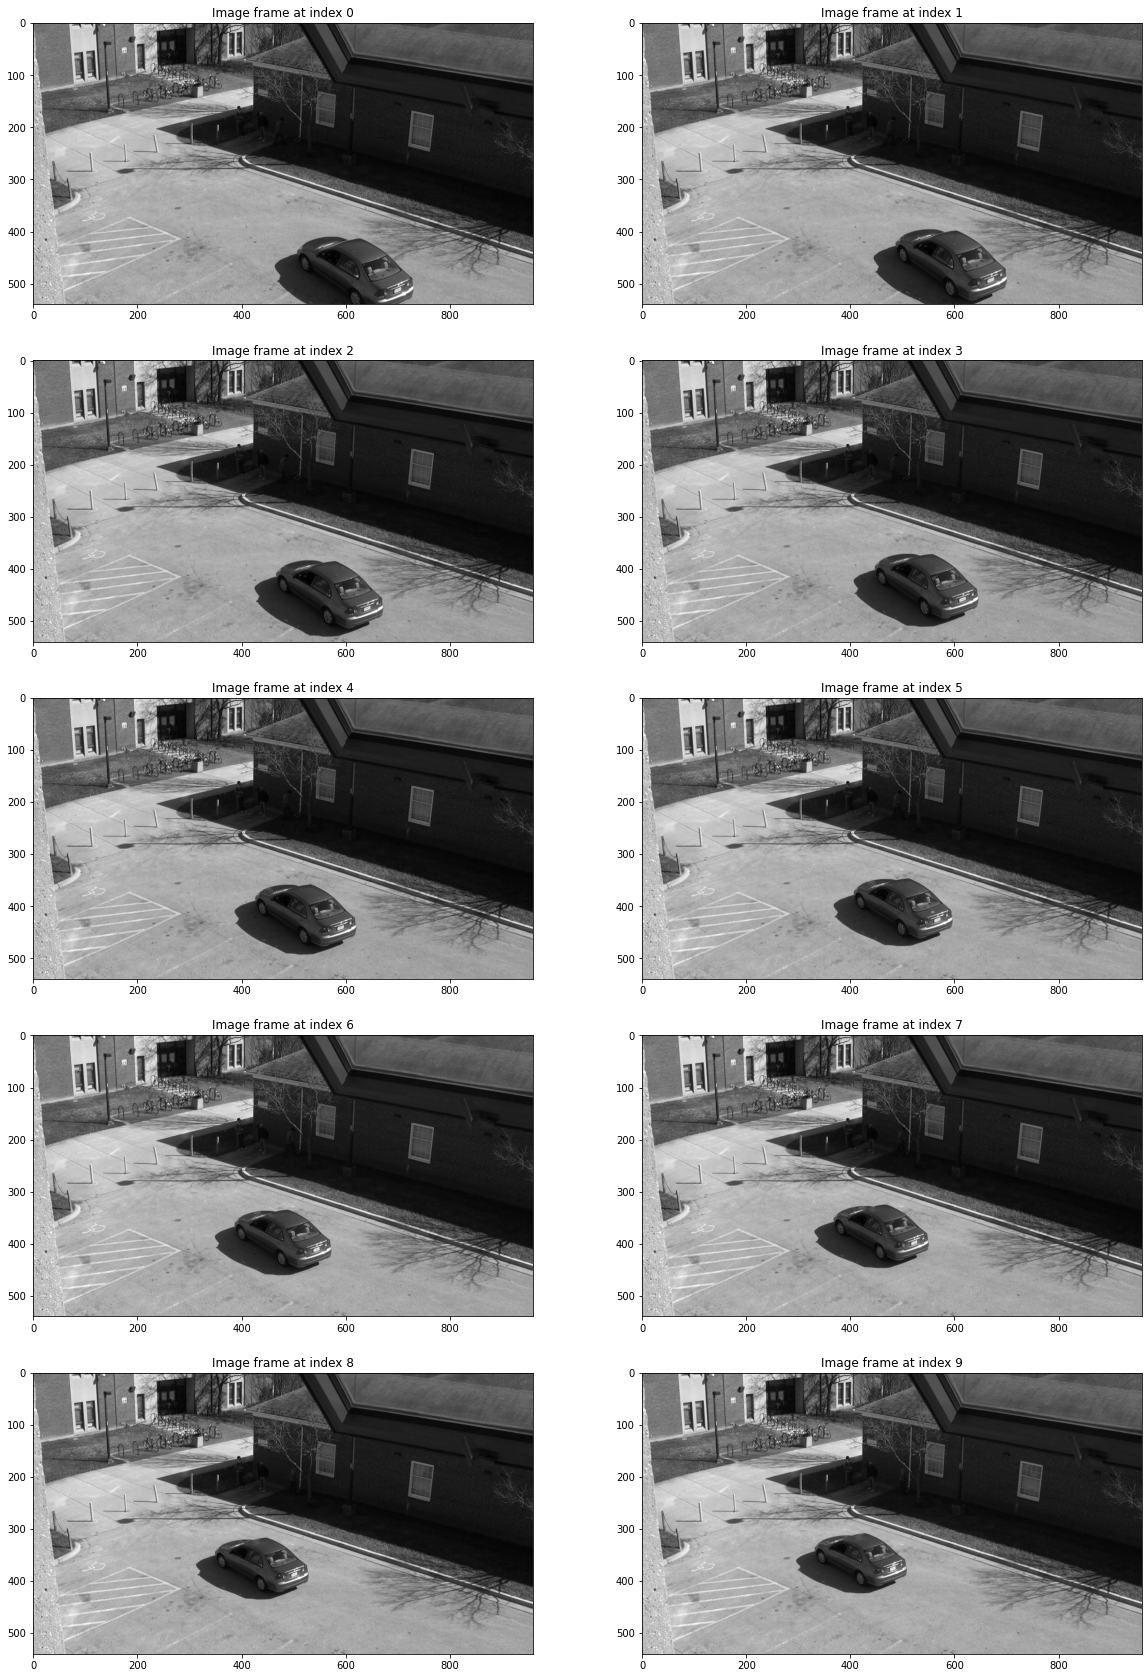

In [13]:
# Load an color image in grayscale

plt.figure(figsize=(20,30))

img = [] # list of images
for i in range (10):
    img.append (cv2.imread('/content/drive/MyDrive/Colab Notebooks/data/VIRAT_S_000101/{}.png'.format(15340+i*5)))
    img[i] = cv2.cvtColor(img[i], cv2.COLOR_BGR2GRAY)
    img[i] = reduce_size(img[i], scale_percent=50)
    img[i] = img[i].astype(np.float)  # need to change type from uint8 to float
    plt.subplot(5,2,i+1)
    plt.imshow(img[i], 'gray')
    plt.title('Image frame at index {}'.format(i))


# Problem Setup
We will differentiate between the state, ${\bf s_t}$, of the moving object and the measurements we make about the movement, ${\bf m_t}$. The moving objects' states are the location of the points on the objects with their velocity and acceleration. 

We might not have measurements for all the state quantities. For instance, we can use the locations of features in the image to estimate the locations of the *underlying* points on the object; this is our measurement. However, for velocity or acceleration, we do not have any direct measurements. The Kalman filtering process will allow us to estimate the full state vector from the state's partial measurement.

We model all this in three steps. The figure below diagrams the different aspects.  First, we will specify the *underlying* state of the points. Second, we will model the measurement process. We do not have direct access to the state. We can only measure some aspects of it. Third, we will specify the model governing the underlying movement - state change model.

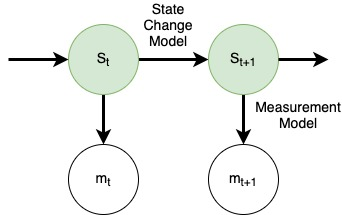

# State specification



    

Let $\mathbf{s}_t$ denote the state of the moving objects at time $t$. Possible choices of the state vector are: just location, 
$\begin{bmatrix}
        x \\ y 
\end{bmatrix}$
or location and velocity
$\begin{bmatrix}
        x \\ y \\ v_x \\ v_y
\end{bmatrix}$
or location, velocity, and bounding box size
$\begin{bmatrix}
        x \\ y \\ w \\ h \\ v_x \\ v_y
\end{bmatrix}$
or location, velocity, acceleration, and bounding box size
$\begin{bmatrix}
        x \\ y \\ w \\ h \\ v_x \\ v_y \\ a_x \\ a_y
\end{bmatrix}$

This state is really a random variable as we do not know the exact value. We assume it is a Gaussian random variable, with a mean value, $\hat{\mathbf{s}}_t$, and a covariance $\mathbf{P}_t$ capturing the uncertainty about the state.




# Measurement Model

We can *measure* the point locations using the Harris detector. However, we do not have measurements for velocity or acceleration. The measurement process consists of running the Harris point detector in the next frame and picking a response in the next frame that is the best match. This measurement is inherently noisy and uncertain. Some points, such as corners, can be located more precisely than others on a boundary edge. We will capture this uncertainty in the measurement model.

A measurement model relates the measurement with the underlying model states. In general, the dimension of the measurement vector would be lower than the state vector.  For instance, we can measure the location directly, but not the velocity or acceleration, so the measurement vector, in that case, will consist of just the location values. 

Let the measurement vector be denoted by  $\mathbf{m}_t$ and the relationship with the state vector $\mathbf{s}_t$ be related by

\begin{equation}
        \mathbf{m}_t = \mathbf{H} \mathbf{s}_t + \mathbf{w}
\end{equation}

where $\mathbf{w}$ is the measurement error, which again will be assumed to be zero mean with some covariance, $\mathbf{R}$, capturing the uncertainty of the measurement. For instance, if you measure the location sum of squared differences between patches from earlier point features, we can use the local image tensor to measure uncertainty.
    
One example of a measurement model for the point tracking case is given by:

\begin{equation}
    \begin{bmatrix}
        r \\ c 
    \end{bmatrix}_{t+1} = 
    \begin{bmatrix}
    1 & 0 & 0 & 0 \\
    0 & 1 & 0 & 0
    \end{bmatrix} 
    \begin{bmatrix}
        x \\ y \\ v_x \\ v_y
    \end{bmatrix}_{t} + 
    \begin{bmatrix}
        w_0 \\ w_1 
    \end{bmatrix}
\end{equation}

**Illustration of measurement**

Below are the Harris points detected in each image with their associated uncertainties depicted using ellipses. We have constructed these ellipses using the local image tensor, ${\bf A}$, as the covariance estimate.


Computing on:  cuda:0


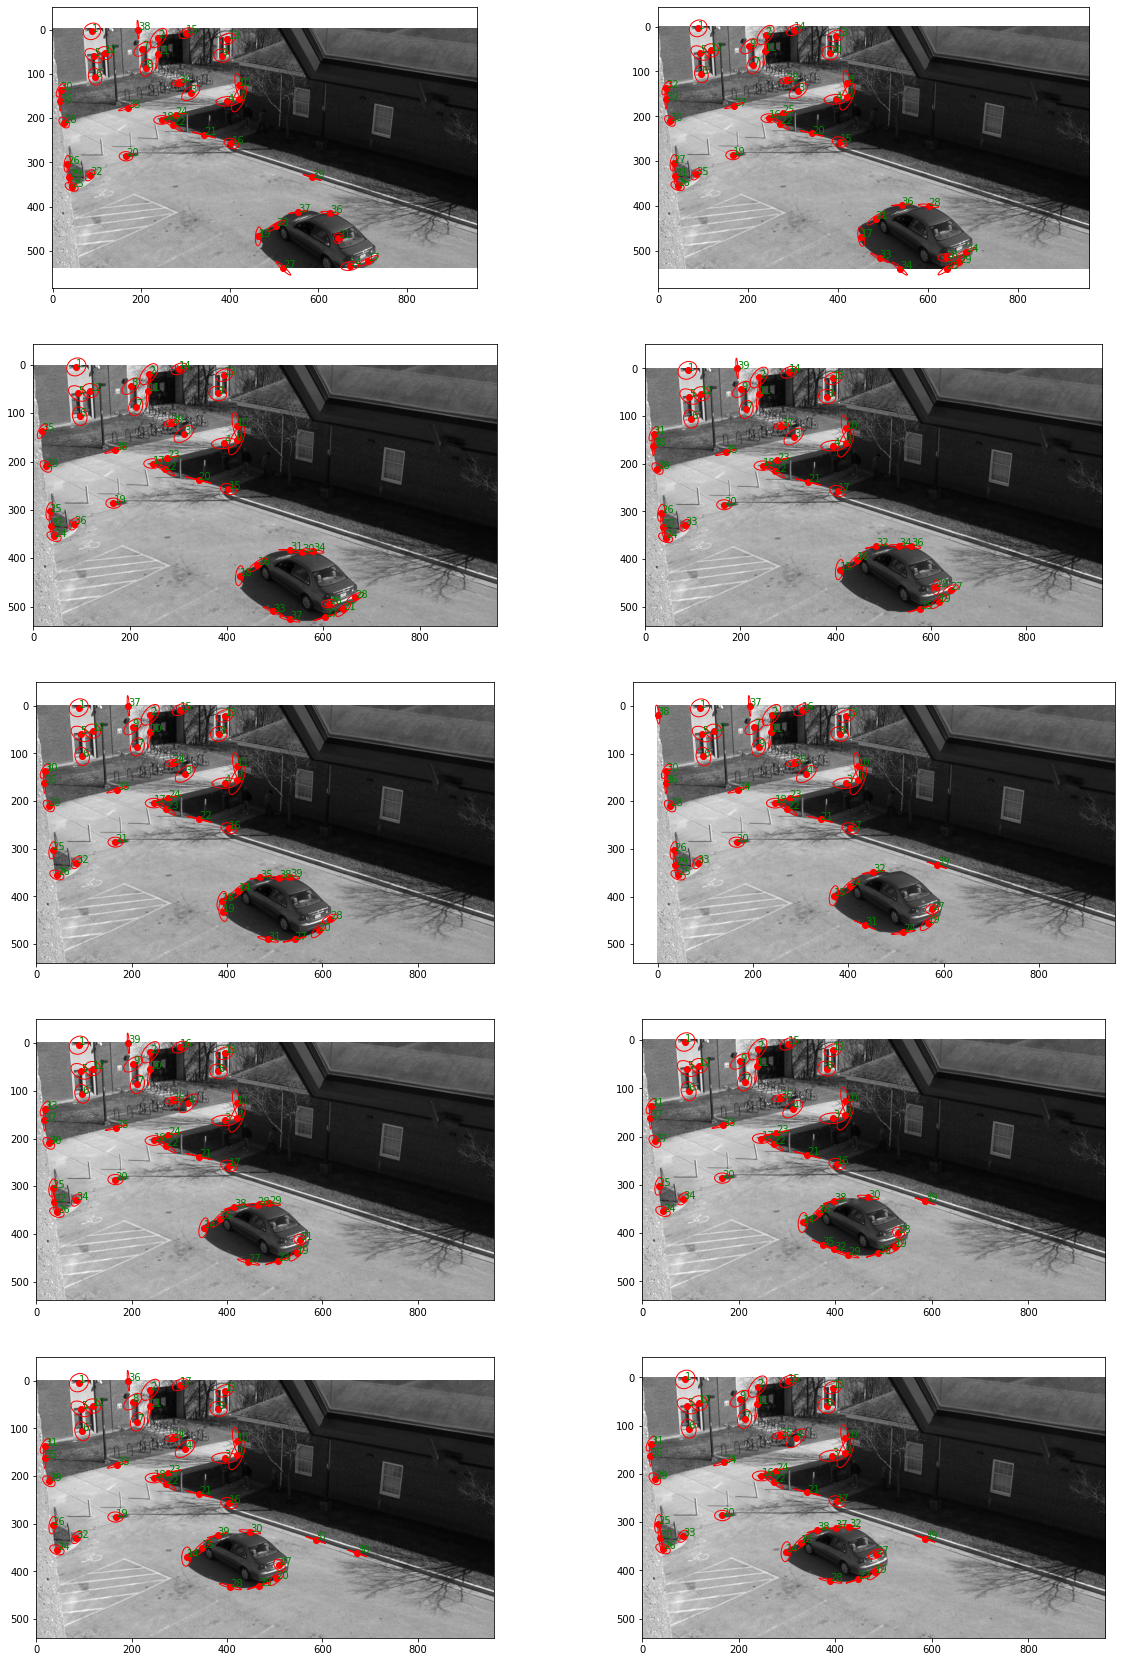

In [14]:
plt.figure(figsize=(20,30))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Computing on: ', device)

for i in range (10) :
    
    input = torch.tensor(img[i], device=device).float()
    input = input[None, None, :] # expand to 4 channels
    harris_image, coords, image_tensor  = detect_harris_points_torch (device, input, sigma=2, min_distance=20, num_peaks=40, figure='no')
    #print(image_tensor.shape, coords.shape)
    #coords, image_tensor = detect_harris_points (img[i], sigma=2, min_distance=20, num_peaks=40)
    # Plot the results
    plt.subplot(5,2,i+1)
    plt.imshow(img[i], 'gray')
    plt.plot(coords[:, 1], coords[:, 0], 'ro')
    for j in range (len(coords)):
        plt.text(coords[j, 1], coords[j, 0], '{}'.format(j), color='g')
    ax = plt.gca()
    for j in range(coords.shape[0]) :
        # exchange x and y to align with (row, column) order of image pixel corodinate specification
        # -- this just for display purposes (y - rows, x - columns)
        # the negative in the image_tensor[j,1] is to invert the direction of Iy in that term to adjust
        # for the fact that the y-axis is negative, with the origin at top left corner.

        cov = np.array([[image_tensor[j,2], -image_tensor[j,1]],[-image_tensor[j,1], image_tensor[j,0]] ])
        p_x = coords[j,0]
        p_y = coords[j,1]
        ax.add_patch(confidence_ellipse(cov, np.array([p_y, p_x]), ax, n_std = 2, edgecolor='red'))


# State Change Model

We assume a linear model of the state change.
\begin{equation}
        \mathbf{s}_{t+1} = \mathbf{A} \mathbf{s}_{t} + \mathbf{n}
\end{equation}

where $\mathbf{n}$ is zero-mean Gaussian noise with covariance $\mathbf{Q}$.

Note that $\mathbf{s}_{t+1} $ is *a linear combination of two Gaussian random variables, so it is also a Gaussian random variable*. 

The matrix ${\bf A}$ is pre-specified based on prior domain knowledge. For instance, we need to model a constant velocity model we can use the following
    
\begin{equation}
    \begin{bmatrix}
        x \\ y \\ v_x \\ v_y
    \end{bmatrix}_{t+1} = 
    \begin{bmatrix}
    1 & 0 & 1 & 0 \\
    0 & 1 & 0 & 1 \\
    0 & 0 & 1 & 0 \\
    0 & 0 & 0 & 1 
    \end{bmatrix} 
    \begin{bmatrix}
        x \\ y \\ v_x \\ v_y
    \end{bmatrix}_{t} + 
    \begin{bmatrix}
        n_0 \\ n_1 \\ n_2 \\ n_3
    \end{bmatrix}
\end{equation}

At each time instant, $t$, the following variables are updated: the mean value of the state $\mathbf{\hat{s}}_t$ and its covariance $\mathbf{P}$. These quantities are effected by the state evolution function and also indirectly by the measurement. So, the update will be in two steps: A forward update, followed by measurement update.



# Forward Update

The state change equation guides the forward update. 

>>>We will use the fact that the addition of two independent Gaussian random variables is also a Gaussian. Let $\mathbf{Y} = \mathbf{X}_1 + \mathbf{X}_2 $, where each of them is Gaussian random variable. Then 
$\mathbf{\widehat{Y}} = \mathbf{\widehat{X}_1} + \mathbf{\widehat{X}_2} $ and $\mathbf{\Sigma}_Y = \mathbf{\Sigma}_{X_1} + \mathbf{\Sigma}_{X_2} $.
    
With this knowledge, we consider the state change model, which is a sum of two independent Gaussian random variables. Recall that the Gaussian random variable representing the states has a mean value, $\hat{\mathbf{s}}_t$, and the covariance $\mathbf{P}_t$. The noise $\mathbf{n}$ is zero-mean Gaussian noise with covariance $\mathbf{Q}$.


The intermediate estimate of the new state and its covariance, just based on the forward model, is given by

\begin{eqnarray}
        \mathbf{\hat{s}}^{-}_{t+1} & =  & \mathbf{A} \mathbf{\hat{s}}_{t} \\
        \mathbf{P}^{-}_{t+1} & =  & \mathbf{A} \mathbf{P}_{t} \mathbf{A}^T + \mathbf{Q}
\end{eqnarray}
    
Note that this is *not* the final estimate of the next state as we have to factor in the measurement. Before that, we compute a quantity called the Kalman gain that captures the relative uncertainties in the measurement and the state models.


# Kalman Gain

The Kalman gain blends the model (intermediate) covariance, $\mathbf{P}^{-}_{t+1}$, and the measurement error covariance, $\mathbf{R}$.

\begin{equation}
        \mathbf{K} = \mathbf{P}^{-}_{t+1} \mathbf{H}^T 
        \left ( \mathbf{H} \mathbf{P}^{-}_{t+1} \mathbf{H}^T  + \mathbf{R}
        \right )^{-1}
\end{equation}

# Measurement Update

\begin{eqnarray}
    \mathbf{\hat{s}}_{t+1} & = & \mathbf{\hat{s}}^{-}_{t+1} + \mathbf{K}  
    \left ( \mathbf{m}_{t+1} - \mathbf{H} \mathbf{\hat{s}}^{-}_{t+1}
    \right )  \\
    \mathbf{P}_{t+1} & = & \left ( \mathbf{I} - \mathbf{K}  \mathbf{H} \right ) \mathbf{P}^{-}_{t+1}
\end{eqnarray}
    
Note how the measurement error, i.e. the terms in parenthesis, is added to the state to update it.
    

# In class work (15 min)

Work through the following example with constant velocity model example shown earlier, with the following values of the other variables you would need.

We assume half a pixel model error noise, which implies that we have faith in the model.

\begin{equation}
    \mathbf{Q}  = 
    \begin{bmatrix} \frac{1}{4} & & \huge0 & \\
    & \frac{1}{4} &  & \\
    & & \frac{1}{4} & \\
    & \huge0 & & \frac{1}{4} \end{bmatrix}
\end{equation}
    
Initial estimate of the covariance model assumes that it is diagonal, uncorrelated dimensions, with 3 pixel standard deviation in location and 5 pixel standard deviation in velocity.

\begin{equation}
    \mathbf{P}_0  = 
    \begin{bmatrix} 9 & & \huge0 & \\
    & 9 &  & \\
    & & 25 & \\
    & \huge0 & & 25 \end{bmatrix}
\end{equation}
    
The measurement error is diagonal too with a standard deviation of 1 pixel.
    \begin{equation}
        \mathbf{R}  = 
        \begin{bmatrix} 1 & 0 \\
        0 & 1  
        \end{bmatrix}
    \end{equation}

Let $\mathbf{\hat{s}}_0 = \begin{bmatrix} 100 \\ 170 \\ 0 \\ 0 \end{bmatrix}$ and measurement be $\mathbf{m}_1 = 
\begin{bmatrix}
        103 \\ 163
\end{bmatrix}$, what is $\mathbf{s}_1$?


# Solution
    
\begin{eqnarray}
    \mathbf{\hat{s}}^{-}_1  & = & 
    \begin{bmatrix}
      & & & \\
      & & & \\
      & & & \\
      & & & 
    \end{bmatrix}^{4 x 4} 
    \begin{bmatrix} 100 \\ 170 \\ 0 \\ 0 \end{bmatrix}^{4 x 1} \\
    & = & \begin{bmatrix} \\ \\  \\ \end{bmatrix}^{4 x 1}
\end{eqnarray}
    
\begin{eqnarray}
    \mathbf{P}^{-}_1  & = &
    \begin{bmatrix}
    1 & 0 & 1 & 0 \\
    0 & 1 & 0 & 1 \\
    0 & 0 & 1 & 0 \\
    0 & 0 & 0 & 1 
    \end{bmatrix} ^{4 x 4} 
    \begin{bmatrix} 9 & & \huge0 & \\
        & 9 &  & \\
        & & 25 & \\
        & \huge0 & & 25 
    \end{bmatrix}
    \begin{bmatrix}
      & & & \\
      & & & \\
      & & & \\
      & & & 
    \end{bmatrix}^{4 x 4}   +
        \begin{bmatrix} \frac{1}{4} & & \huge0 & \\
        & \frac{1}{4} &  & \\
        & & \frac{1}{4} & \\
        & \huge0 & & \frac{1}{4} \end{bmatrix} \\
    & = & 
    \begin{bmatrix}
      & & & \\
      & & & \\
      & & & \\
      & & & 
    \end{bmatrix}^{4 x 4} 
\end{eqnarray}
    
This state prediction gives us a location to relocate the new location and the covariance estimate gives us an area to consider. In our case this is a circle centered at $(100, 170)$ and with radius $\sqrt{34.25} = 5.85$ pixels. We can run the SSD detector and make a new measurement. $\mathbf{m}_1 = \begin{bmatrix}
        103 \\ 163
\end{bmatrix}$

\begin{equation}
        \mathbf{K} = \mathbf{P}^{-}_{t+1} \mathbf{H}^T 
        \left ( \mathbf{H} \mathbf{P}^{-}_{t+1} \mathbf{H}^T  + \mathbf{R}
        \right )^{-1}
\end{equation}


\begin{eqnarray}
    \mathbf{K}  & = &
    \begin{bmatrix}
    0.972 & 0  \\
    0 & 0.972  \\
    0.709 & 0  \\
    0 & 0.709  
    \end{bmatrix} 
\end{eqnarray}
    
The entries capture how much to weight the measurement. Values close to 1 suggest trust the measurement.
    
\begin{eqnarray}
    \mathbf{\hat{s}}_{1} & = & \mathbf{\hat{s}}^{-}_{1} + \mathbf{K}  
    \left ( \mathbf{m}_{1} - \mathbf{H} \mathbf{\hat{s}}^{-}_{1}
    \right )  \\
    & = & \begin{bmatrix}  \\  \\  \\  \end{bmatrix}^{4 x 1} 
    + \begin{bmatrix}
    0.972 & 0  \\
    &  \\
     & 0  \\
    0 &   
    \end{bmatrix}^{4 x 2} \left (
    \begin{bmatrix}
        103 \\ 163
    \end{bmatrix}  - \begin{bmatrix}
     &  &  &  \\
     &  &  & 
    \end{bmatrix}^{2 x 4} 
    \begin{bmatrix}  \\  \\  \\  \end{bmatrix}^{4 x 1} 
    \right ) \\
    & = & \begin{bmatrix}  \\  \\  \\  \end{bmatrix}^{4 x 1} 
\end{eqnarray}

    
\begin{eqnarray}
    \mathbf{P}_{1} & = & \left ( \mathbf{I} - \mathbf{K}  \mathbf{H} \right ) \mathbf{P}^{-}_{1} \\
    & = & 
    \left (
    \begin{bmatrix}
    1 & 0 & 0 & 0 \\
    0 & 1 & 0 & 0 \\
    0 & 0 & 1 & 0 \\
    0 & 0 & 0 & 1 
    \end{bmatrix}  -
    \begin{bmatrix}
    0.972 & 0  \\
     &   \\
     & 0 \\
    0 & 
    \end{bmatrix}^{4 x 2} 
    \begin{bmatrix}
    1 & 0 & 0 & 0 \\
    0 & 1 & 0 & 0
    \end{bmatrix} 
    \right )
    \begin{bmatrix}
     & 0 & 25 & 0 \\
    0 & & 0 & 25 \\
     & 0 &  & 0 \\
    0 &  & 0 &  
    \end{bmatrix}^{4 x 4} \\
    & = & 
    \begin{bmatrix}
     & 0 & 0.71 & 0 \\
    0 &  & 0 &  \\
     & 0 & & 0 \\
    0 & 0.71 & 0 & 7.52 
    \end{bmatrix}^{4 x 4}
\end{eqnarray}
    
Note how the covariance matrix is not diagonal anymore.

# Kalman filter code

In [15]:
import matplotlib.patches as patches

#-------------------------------define update functions ---------------------------------------------
def forward_update (s_hat_t, P_t, A, Q) :
    s_minus_next = A @ s_hat_t
    P_minus_next = A @ P_t @ np.transpose(A) + Q
    return (s_minus_next, P_minus_next)

def compute_kalman_gain (P_minus_next, H, R) :
    return (P_minus_next @ np.transpose(H) @ (np.linalg.inv(H @ P_minus_next @ np.transpose(H) + R)))

def measurement_update (s_minus_next, P_minus_next, measurement, H,  K) :
    s_hat_next = s_minus_next + K @ (measurement - H @ s_minus_next)
    P_next = (np.eye(K.shape[0]) - K @ H) @ P_minus_next
    return (s_hat_next, P_next)

def perform_measurement (file_name, point, covariance) :
# read in an image from file_name and
# return nearest harris point to (px, py) along with measurement error use
# covariance to limit search, however, here we do a fairly brute force method
# of detecting all Harris points and then selecting the nearest one
    image = cv2.imread(file_name)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = reduce_size(image, scale_percent=50)
    image = image.astype(np.float)  # need to change type from uint8 to float
    input = torch.tensor(image, device=device).float()
    input = input[None, None, :] # expand to 4 channels
    harris_image, coords, image_tensor  = detect_harris_points_torch (device, input, sigma=2, min_distance=20, num_peaks=40, figure='no')
    #coords, image_tensor = detect_harris_points (image, sigma=2, min_distance=20, num_peaks=40)
    if len(point) != 0 :
        dist = distance (np.transpose(point), coords)
        min_index = np.argmin(dist);
        return(image, coords[min_index,:][:,None], image_tensor[min_index,:])
    else:
        return(image, coords, image_tensor)




# Track a Harris point using Kalman filtering

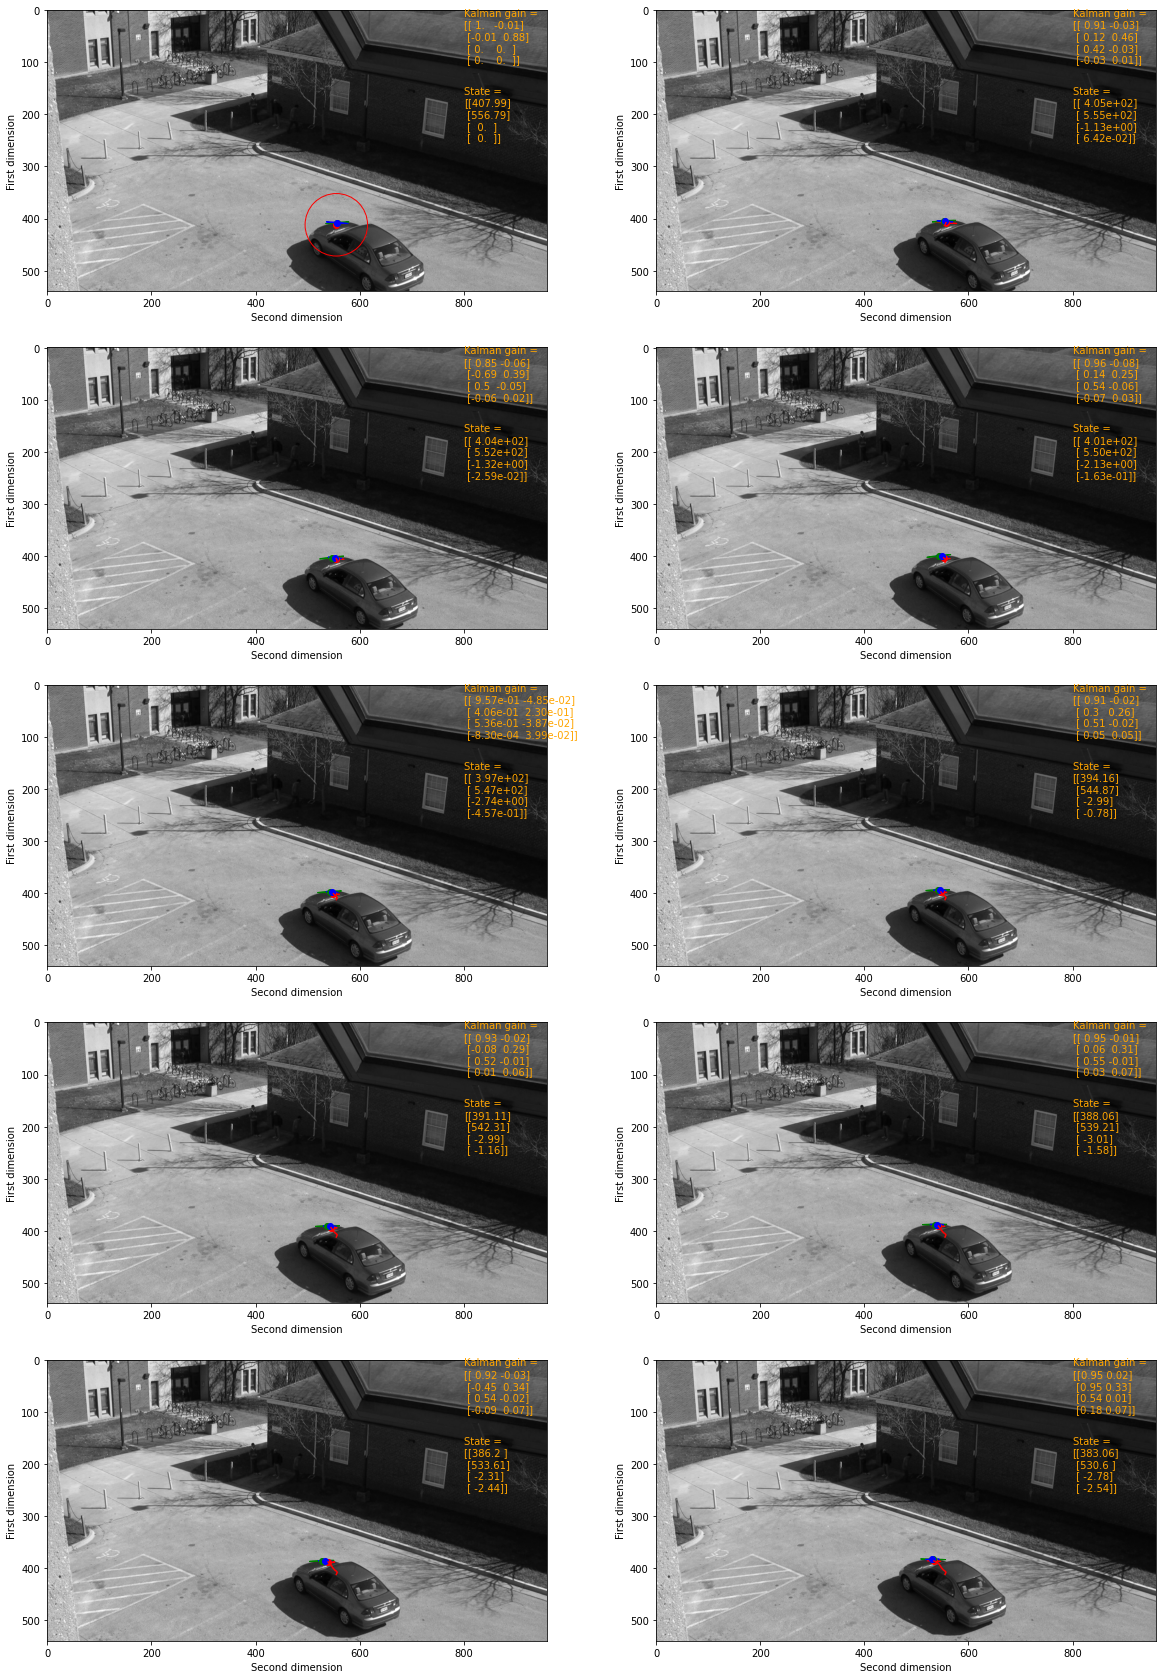

In [18]:
#---------------------------Initialization----------------------------------------------------
# Initialization -- choose a point to track in the first image

in_file = '/content/drive/MyDrive/Colab Notebooks/data/VIRAT_S_000101/{}.png'.format(15340)
image1, coords, image_tensor = perform_measurement (in_file, [], [])

#---------------------------------------------------------------------------
point_tracked = 37
#---------------------------------------------------------------------------

# --- State change model parameters ---------------------------------
# the state mean is a 4 by 1 vector of 2D location and 2D velocity. Initialized to zero velocity
current_state = np.array([[coords[point_tracked,0]], [coords[point_tracked,1]], [0], [0]]) #
# the state covariance is a diagonal matrix with standard deviation of 30 pixels
# representing wide uncertainty of initial estimates
current_state_covariance = np.zeros((4,4))
current_state_covariance[0,0] = 900
current_state_covariance[1,1] = 900
state_change_model = np.array([[1, 0, 1, 0], [0, 1, 0, 1], [0, 0, 1, 0], [0, 0, 0, 1]])
model_covariance = np.eye(4)  # noise covariance -- denotes high confidence in the model.

# --- Measurement process parameters ---------------------------------
measurement_model = np.array([[1, 0, 0, 0], [0, 1, 0, 0]])
measurement_covariance = [[image_tensor[point_tracked,0], image_tensor[point_tracked,1]],
                          [image_tensor[point_tracked,1], image_tensor[point_tracked,2]]]# Use the image tensor around the point as an estimate of the measurement covariance

#-------------------------------------------------------------------------
plt.figure(figsize=(20,30))
state_history = []
for i in range (1, 11) :
    # ----- Run forward model ---------------
    intermediate_state, intermediate_model_covariance = forward_update (current_state, current_state_covariance, state_change_model, model_covariance)

    #-------Perform Measurement ---------
    # read in next frame
    in_file = '/content/drive/MyDrive/Colab Notebooks/data/VIRAT_S_000101/{}.png'.format(15340+i)
    image2, measurement, image_tensor = perform_measurement (in_file, intermediate_state[0:2,:], intermediate_model_covariance[0:2,0:2])
    
    measurement_covariance = np.array([[image_tensor[0], image_tensor[1]],[image_tensor[1], image_tensor[2]] ])
    #------- Compute Kalman Gain ------------
    kalman_gain = compute_kalman_gain (intermediate_model_covariance, measurement_model, measurement_covariance)
    
    #-------Measurement Update---------
    next_state, next_state_covariance = measurement_update (intermediate_state, intermediate_model_covariance, measurement, measurement_model,  kalman_gain)
    #
    
    #----------------------------------Display Code---------------------------------
    # Plot the image along with detected features
    plt.subplot(5, 2, np.int((i-1)/1)+1)
    plt.imshow(image2, 'gray')
    plt.xlabel('Second dimension')
    plt.ylabel('First dimension')
    ax = plt.gca()
        
    # plot the start state in red
    plt.plot(current_state[1,0], current_state[0,0], 'ro')
    loc_covariance = np.array([[current_state_covariance[1,1], current_state_covariance[0,1]], [current_state_covariance[1,0], current_state_covariance[0,0]]])
    ax.add_patch(confidence_ellipse(loc_covariance, [current_state[1,0], current_state[0,0]], ax, n_std = 2, edgecolor='red'))

    # plot the measurement in green
    plt.plot(measurement[1,0], measurement[0,0], 'go')
    loc_covariance = np.array([[measurement_covariance[1,1], -measurement_covariance[0,1]], [-measurement_covariance[1,0], measurement_covariance[0,0]]])
    ax.add_patch(confidence_ellipse(loc_covariance, [measurement[1,0], measurement[0,0]], ax, n_std = 2, edgecolor='green'))
    ax.text(800, 100, 'Kalman gain = \n{}'.format(kalman_gain), color='orange')
    ax.text(800, 250, 'State = \n{}'.format(next_state), color='orange')

    # plot the next state in blue
    plt.plot(next_state[1,0], next_state[0,0], 'bo')
    loc_covariance = np.array([[next_state_covariance[1,1], next_state_covariance[0,1]], [next_state_covariance[1,0], next_state_covariance[0,0]]])
    ax.add_patch(confidence_ellipse(loc_covariance, [next_state[1,0], next_state[0,0]], ax, n_std = 2, edgecolor='blue'))
    #-----------------------------------------------------------------------------------------

    state_history.append(current_state)
    current_state = next_state
    current_state_covariance = next_state_covariance
    image1 = image2

    tracked_locations = np.asarray(state_history) # change a list of 4 by 1 state vector (state_history) to a 3D array of N by 4 by 1 size
    plt.plot(tracked_locations[:,1,0], tracked_locations[:,0,0], 'r')
